In [9]:
import sys
sys.executable

import torch, gc
gc.collect()
torch.cuda.empty_cache()


In [10]:
import os
import torch
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from transformers import AutoProcessor, AutoModel
from datasets import load_dataset, Audio
from train_classifier import extract_all_layer_features, extract_single_layer_feature
import joblib
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained("/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/checkpoints_distilhubert_asr/final_model").to(device)
processor = AutoProcessor.from_pretrained("/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/checkpoints_distilhubert_asr/final_model")

In [4]:
dataset = load_dataset("audiofolder", 
                       data_dir="/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/data/LibriSpeech/train-other-500")["train"]
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

Resolving data files:   0%|          | 0/151472 [00:00<?, ?it/s]

In [7]:
# Test
small_dataset = load_dataset(
    "audiofolder",
    data_dir="/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/data/LibriSpeech/train-other-500/3885"
)["train"]

print("Loaded dataset:", len(small_dataset))
print("Example:", small_dataset[0])

# Ensure 16kHz sampling rate
small_dataset = small_dataset.cast_column("audio", Audio(sampling_rate=16000))


Resolving data files:   0%|          | 0/178 [00:00<?, ?it/s]

Loaded dataset: 173
Example: {'audio': {'path': '/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/data/LibriSpeech/train-other-500/3885/1193/3885-1193-0000.flac', 'array': array([ 0.00021362,  0.00024414,  0.00027466, ..., -0.00094604,
       -0.00094604, -0.00106812]), 'sampling_rate': 16000}, 'label': 0}


Extracting features from all layers...


100%|█████████████████████████████████████████| 173/173 [00:02<00:00, 61.59it/s]



Training GMM for Layer 0...
Layer 0 feature shape: (73978, 768)
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
Initialization converged.
Layer 0 - Entropy Mean: 0.0010, Std: 0.0173

Training GMM for Layer 1...
Layer 1 feature shape: (73978, 768)
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged.
Layer 1 - Entropy Mean: 0.0032, Std: 0.0364

Training GMM for Layer 2...
Layer 2 feature shape: (73978, 768)
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged.
Layer 2 - Entropy Mean: 0.0015, Std: 0.0234


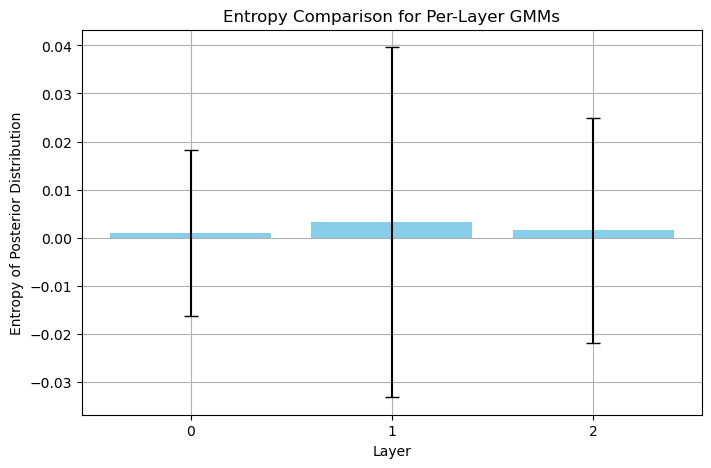

In [11]:
# Extract all 3 layers at once and split them
layer_features = {0: [], 1: [], 2: []}

print("Extracting features from all layers...")
for example in tqdm(small_dataset):
    waveform = processor(example["audio"]["array"], sampling_rate=16000, return_tensors="pt").input_values.to(device)
    with torch.no_grad():
        outputs = model(waveform, output_hidden_states=True)
        hidden_states = outputs.hidden_states  # [embedding, layer1, layer2]
        for layer in [0, 1, 2]:
            layer_features[layer].append(hidden_states[layer].squeeze(0).cpu().numpy())

# Now train GMMs layer by layer
n_components = 500
layer_gmms = {}
entropy_stats = {}

for layer in [0, 1, 2]:
    print(f"\nTraining GMM for Layer {layer}...")
    X = np.concatenate(layer_features[layer], axis=0)
    print(f"Layer {layer} feature shape: {X.shape}")

    gmm = GaussianMixture(n_components=n_components, covariance_type="diag", reg_covar=1e-2, max_iter=100, verbose=1)
    gmm.fit(X)
    layer_gmms[layer] = gmm

    posterior = gmm.predict_proba(X)
    entropy = -np.sum(posterior * np.log(posterior + 1e-8), axis=1)
    entropy_stats[layer] = (entropy.mean(), entropy.std())
    print(f"Layer {layer} - Entropy Mean: {entropy.mean():.4f}, Std: {entropy.std():.4f}")

# Plot entropy mean and std for each layer
means = [entropy_stats[layer][0] for layer in [0, 1, 2]]
stds = [entropy_stats[layer][1] for layer in [0, 1, 2]]

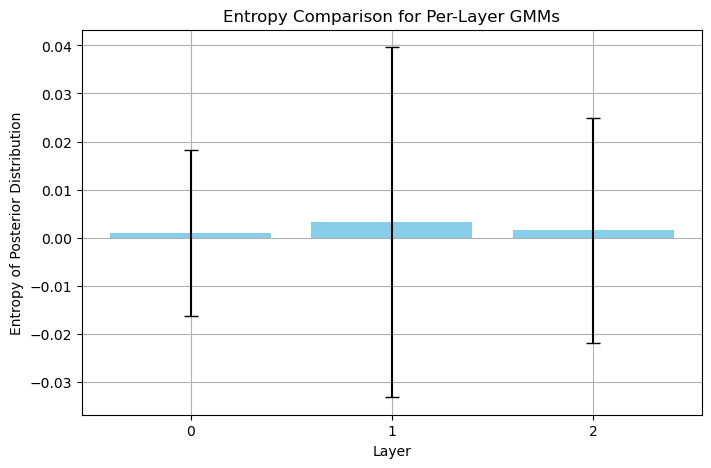

In [12]:
plt.figure(figsize=(8, 5))
plt.bar([0, 1, 2], means, yerr=stds, capsize=5, color='skyblue')
plt.xlabel("Layer")
plt.ylabel("Entropy of Posterior Distribution")
plt.title("Entropy Comparison for Per-Layer GMMs")
plt.xticks([0, 1, 2])
plt.grid(True)
plt.show()

In [ ]:
# Select best-performing layer (highest entropy mean)
best_layer = max(entropy_stats.items(), key=lambda x: x[1][0])[0]
print(f"Best Layer Selected for Final GMM: {best_layer}")

# Train final GMM on same data using best layer
X_full = np.concatenate(layer_features[best_layer], axis=0)
final_gmm = GaussianMixture(n_components=n_components, covariance_type="diag", reg_covar=1e-2, max_iter=100, verbose=1)
final_gmm.fit(X_full)

# Save final GMM
import joblib
joblib.dump(final_gmm, f"final_gmm_layer{best_layer}.pkl")
print(f"Saved final GMM as final_gmm_layer{best_layer}.pkl")